# M02. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 4/19/2024
    - Updated: 4/21/2024

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [3]:
%run "A02. MLB API.ipynb"
%run "A03. Steamer.ipynb"

In [4]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dataset

In [5]:
complete_dataset = create_pa_inputs(park_factors, team_map, 2015, 2024, short=50, long=300)

In [6]:
# UPDATE IN IMPORTS
year_inputs = [f"year_{year}" for year in range(2015,2025)]

In [7]:
year_inputs

['year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'year_2019',
 'year_2020',
 'year_2021',
 'year_2022',
 'year_2023',
 'year_2024']

##### Inputs

In [8]:
# Standardize
complete_dataset[batter_inputs] = batter_stats_scaler.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = pitcher_stats_scaler.transform(complete_dataset[pitcher_inputs])

### Steamer

In [9]:
# Read in Steamer hitters 
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

In [10]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [11]:
# Standardize
steamer_hitters_df2[batter_stats_fg] = batter_stats_fg_scaler.transform(steamer_hitters_df2[batter_stats_fg])
steamer_pitchers_df2[pitcher_stats_fg] = pitcher_stats_fg_scaler.transform(steamer_pitchers_df2[pitcher_stats_fg])

### Merge

In [12]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
batter_steamer_dates = list(steamer_hitters_df2['date'].unique())
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["batter_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, batter_steamer_dates))
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [13]:
# Steamer stats we want to keep
batter_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + batter_stats_fg 
pitcher_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + pitcher_stats_fg 

# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_hitters_df2[batter_stats_fg_plus], left_on=['batter', 'batter_date'], right_on=['mlbamid', 'date'], how='inner')
complete_merged_df = pd.merge(complete_merged_df, steamer_pitchers_df2[pitcher_stats_fg_plus], left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='inner')

### Impute

##### Option 1: Steamer

In [14]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = batter_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = pitcher_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

##### Option 2: 0s

In [15]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Train Models

##### Dataset

In [16]:
# Filter out events that didn't end with reaching base or an out
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"').reset_index(drop=True)
# Drop early observations (these will generally treat veterans as rookies and could bias results
complete_merged_df = complete_merged_df.drop(index=complete_merged_df.index[:20000])
complete_merged_df.reset_index(inplace=True, drop=True)
# Create year variable
complete_merged_df['year'] = complete_merged_df['date'].astype('str').str[:4]
# Create is_out binary variable
out_list = ['so', 'fo', 'go', 'lo', 'po']
complete_merged_df['is_out'] = complete_merged_df['eventsModel'].str.contains('|'.join(out_list)).astype(int)

##### Create Park/Weather Inputs

In [17]:
active_parks = list(team_map['VENUE_ID'])
active_venues = [f"venue_{park}" for park in active_parks]
complete_merged_df['active_park'] = complete_merged_df[active_venues].sum(axis=1)

In [18]:
# Add lefty dummy
complete_merged_df['lefty'] = (complete_merged_df['batSide'] == "L").astype(int)

# # Create interaction terms
# interaction_terms = []
# for col1 in ['x_vect', 'y_vect', 'temperature'] + year_inputs:
#     for col2 in active_venues + ['lefty']:
#         interaction_name = col1 + '_' + col2
#         complete_merged_df[interaction_name] = complete_merged_df[col1] * complete_merged_df[col2]
#         interaction_terms.append(interaction_name)

# complete_merged_df['x_vect_temperature'] = complete_merged_df['x_vect'] * complete_merged_df['temperature']
# complete_merged_df['y_vect_temperature'] = complete_merged_df['y_vect'] * complete_merged_df['temperature']
# complete_merged_df['x_vect_y_vect'] = np.abs(complete_merged_df['x_vect']) * complete_merged_df['y_vect']
# interaction_terms.extend(['x_vect_temperature', 'y_vect_temperature', 'x_vect_y_vect'])

# Step 2: Create interaction terms
interaction_terms = []
# Weather x Park
for col1 in ['x_vect', 'y_vect', 'temperature']:
    for col2 in active_venues:
        interaction_name = col1 + '_' + col2
        complete_merged_df[interaction_name] = complete_merged_df[col1] * complete_merged_df[col2]
        interaction_terms.append(interaction_name)
# Weather x Park x batSide
for col1 in ['x_vect', 'y_vect', 'temperature']:
    for col2 in active_venues:
        for col3 in ['lefty']:
            interaction_name = col1 + '_' + col2 + '_' + col3
            complete_merged_df[interaction_name] = complete_merged_df[col1] * complete_merged_df[col2] * complete_merged_df[col3]
            interaction_terms.append(interaction_name)
# Year x Park
for col1 in year_inputs:
    for col2 in active_venues:
        interaction_name = col1 + '_' + col2
        complete_merged_df[interaction_name] = complete_merged_df[col1] * complete_merged_df[col2]
        interaction_terms.append(interaction_name)
# Weather x Park x batSide
for col1 in year_inputs:
    for col2 in active_venues:
        for col3 in ['lefty']:
            interaction_name = col1 + '_' + col2 + '_' + col3
            complete_merged_df[interaction_name] = complete_merged_df[col1] * complete_merged_df[col2] * complete_merged_df[col3]
            interaction_terms.append(interaction_name)
# batSide x Park
for col1 in ['lefty']:
    for col2 in active_venues:
        interaction_name = col1 + '_' + col2
        complete_merged_df[interaction_name] = complete_merged_df[col1] * complete_merged_df[col2]
        interaction_terms.append(interaction_name)
complete_merged_df['x_vect_temperature'] = np.abs(complete_merged_df['x_vect']) * complete_merged_df['temperature']
complete_merged_df['y_vect_temperature'] = complete_merged_df['y_vect'] * complete_merged_df['temperature']
complete_merged_df['x_vect_y_vect'] = np.abs(complete_merged_df['x_vect']) * complete_merged_df['y_vect']
interaction_terms.extend(['x_vect_temperature', 'y_vect_temperature', 'x_vect_y_vect'])

In [19]:
# for event in events_list:
for event in events_list:
    print(event)
    # Determine actual rate (unadjusted)
    complete_merged_df[f'actual_{event}'] = (complete_merged_df[f'{event}'] > 0).astype(int)
    
    # Can't use {event}_b and {event}_p because they are currently scaled. Need unscaled as input.
    # Create copy to replace with later
    complete_merged_df[f'{event}_b_copy'] = complete_merged_df[f'{event}_b'].copy()
    complete_merged_df[f'{event}_p_copy'] = complete_merged_df[f'{event}_p'].copy()
    # Replace with averages
    complete_merged_df[f'{event}_b'] = complete_merged_df[f'actual_{event}'].mean()
    complete_merged_df[f'{event}_p'] = complete_merged_df[f'actual_{event}'].mean()

    # List of inputs
    weather_inputs = [f'{event}_b', f'{event}_p', 'x_vect', 'y_vect', 'temperature', 'lefty'] + year_inputs + interaction_terms
    
    # Step 5: Make predictions
    model = globals().get(event + '_model')
    predictions = model.predict(complete_merged_df[weather_inputs])
    
    # Step 6: Calculate deciles based on predicted 
    complete_merged_df[f'predicted_{event}'] = predictions
    complete_merged_df[f'actual_{event}'] = (complete_merged_df[f'{event}'] > 0).astype(int)
    complete_merged_df[f'{event}_factor'] = complete_merged_df[f'predicted_{event}'] / (pd.to_numeric(complete_merged_df[f'actual_{event}']).astype(np.float64).mean())

    # Fix scaled stats after predicting
    complete_merged_df[f'{event}_b'] = complete_merged_df[f'{event}_p_copy'].copy()
    complete_merged_df[f'{event}_p'] = complete_merged_df[f'{event}_p_copy'].copy()


b1
b2
b3
hr
bb
hbp
so
fo
go
lo
po


In [20]:
pa_inputs2 = ['b1_b', 'b2_b', 'b3_b', 'hr_b', 'bb_b', 'hbp_b', 'so_b', 'fo_b', 'go_b', 'lo_b', 'po_b', 'estimated_woba_using_speedangle_b', 
              'to_left_b', 'to_middle_b', 'to_right_b', 'hard_hit_b', 'barrel_b', 'iso_b', 'slg_b', 'obp_b', 'woba_b', 'totalDistance_b', 
              'launchSpeed_b', 'b1_b_long', 'b2_b_long', 'b3_b_long', 'hr_b_long', 'bb_b_long', 'hbp_b_long', 'so_b_long', 'fo_b_long',
              'go_b_long', 'lo_b_long', 'po_b_long', 'estimated_woba_using_speedangle_b_long', 'to_left_b_long', 'to_middle_b_long',
              'to_right_b_long', 'hard_hit_b_long', 'barrel_b_long', 'iso_b_long', 'slg_b_long', 'obp_b_long', 'woba_b_long', 'totalDistance_b_long',
              'launchSpeed_b_long', 'b1_p', 'b2_p', 'b3_p', 'hr_p', 'bb_p', 'hbp_p', 'so_p', 'fo_p', 'go_p', 'lo_p', 'po_p', 
              'estimated_woba_using_speedangle_p', 'to_left_p', 'to_middle_p', 'to_right_p', 'hard_hit_p', 'barrel_p', 'iso_p',
              'slg_p', 'obp_p', 'woba_p', 'maxSpeed_p', 'maxSpin_p', 'b1_p_long', 'b2_p_long', 'b3_p_long', 'hr_p_long', 'bb_p_long',
              'hbp_p_long', 'so_p_long', 'fo_p_long', 'go_p_long', 'lo_p_long', 'po_p_long', 'estimated_woba_using_speedangle_p_long', 
              'to_left_p_long', 'to_middle_p_long', 'to_right_p_long', 'hard_hit_p_long', 'barrel_p_long', 'iso_p_long', 'slg_p_long',
              'obp_p_long', 'woba_p_long', 'maxSpeed_p_long', 'maxSpin_p_long', 'p_L', 'b_L', 'onFirst', 'onSecond', 'onThird', 'inning',
              'top', 'outs_pre', 'score_diff', 'imp_b', 'imp_p', 'starter'] + [f'{event}_factor' for event in events_list]

In [21]:
# Keep relevant variables
keep_list = pa_inputs2 + ['pa_b', 'pa_p', 'year', 'venue_id', 'is_out', 'eventsModel', 'batterName', 'pitcherName']
model_dataset = complete_merged_df.query('active_park == 1')[keep_list].reset_index(drop=True)

In [22]:
outs_dataset = model_dataset[model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset = model_dataset[~model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

### Train/Test Split

##### Option 1: Early/Late Season

In [23]:
# X_train = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.head(int(len(x)*2/3)))
# X_test = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

##### Option 2: Random

In [24]:
np.random.seed(42)

# Create a column 'split' with random values to achieve a 2/3 to 1/3 split
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

# Drop if missing information
model_dataset.dropna(subset=pa_inputs2, inplace=True)
model_dataset.columns = model_dataset.columns.astype(str)

# Split the DataFrame into training and testing sets based on the 'split' column
X_train = model_dataset[model_dataset['split'] == 0].drop('split', axis=1)
X_test = model_dataset[model_dataset['split'] == 1].drop('split', axis=1)

In [25]:
outs_dataset_train = X_train[X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_train = X_train[~X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [26]:
outs_dataset_test = X_test[X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_test = X_test[~X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [27]:
# del complete_merged_df, complete_dataset, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2  

In [28]:
# get rid of spring training! I can't believe it's still in there. Sholdn't matter tho

### Outs vs. Safe

In [335]:
%%time
# This is good! layers = (250,250,250,250,250) x 10 (just takes a while to run) It's good by year too
# layers = (10,10)
layers = (250,250,250,250,250)

binary_filename = f"model_binary_voting_{todaysdate}.sav"
print(binary_filename)

iters = 100

state = 100

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=state+1, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=state+2, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=state+3, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=state+4, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=state+5, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    ]


# Create the ensemble classifier using VotingClassifier
model_binary = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-1).fit(X_train[pa_inputs2], X_train[['is_out']].values.ravel())

# Save model
pickle.dump(model_binary, open(os.path.join(model_path, binary_filename), 'wb'))

model_binary_voting_20240424.sav
CPU times: total: 969 ms
Wall time: 35min 5s


In [336]:
# Make predictions
proba = model_binary.predict_proba(X_test[pa_inputs2])
X_test['is_safe_pred'] = proba[:, 0]  # Assign the first column of probabilities
X_test['is_out_pred']  = proba[:, 1]  # Assign the second column of probabilities

3    BOS
Name: BBREFTEAM, dtype: object


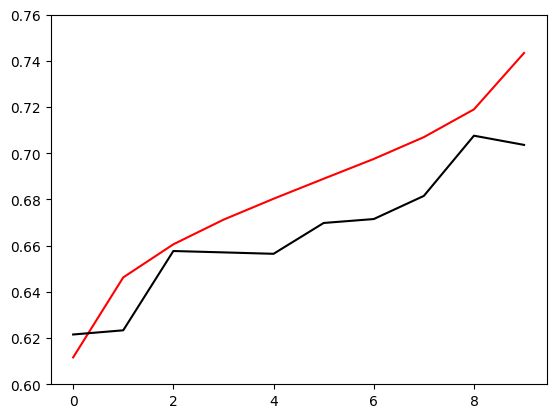

In [341]:
park = 3
venue = active_parks[park]
print(team_map.query(f'VENUE_ID == {venue}')['BBREFTEAM'])

X_test['decile'] = pd.qcut(X_test['is_out_pred'], 10, labels=False)

globals()["is_out_df"] = X_test.groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()
globals()["is_out_df"] = X_test[X_test['year'].astype(int) >= 2022].groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()
globals()["is_out_df"] = X_test.query(f'venue_id == "{active_parks[park]}"').groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()

# Post Processing:
# Create dataframe to adjust predictions to better fit test data
out_df = X_test.groupby('decile').agg({'is_out_pred': ['max', 'mean'], 'is_out': 'mean'})
out_df.columns = ['is_out_pred_max', 'is_out_pred_mean', 'is_out_mean']

out_df.to_pickle(os.path.join(model_path, 'out_df.pkl'))

plt.ylim(0.6, 0.76)

# Create figures
plt.plot(is_out_df['decile'], is_out_df['is_out_pred'], color='red')
plt.plot(is_out_df['decile'], is_out_df['is_out'], color='black')
plt.show() 

In [330]:
# 0.61-.74 still seems too close

### Outs

In [33]:
%%time
# Neural network layers
layers = (25,25,25)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 100

outs_filename = f"model_outs_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(outs_filename)

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.00001, early_stopping=True, validation_fraction=0.1, random_state=3, max_iter=iters),

    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=1, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=2, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=3, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),

]

# Create the ensemble classifier using VotingClassifier
model_outs = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(outs_dataset_train[pa_inputs2], outs_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_outs, open(os.path.join(model_path, outs_filename), 'wb'))

model_outs_relu_252525_100_20240424.sav
CPU times: total: 453 ms
Wall time: 36 s


In [34]:
# Predict out types
outs_outputs = list(model_outs.classes_)
outs_outputs_pred = [x + "_pred" for x in outs_outputs]

proba = model_outs.predict_proba(outs_dataset_test[pa_inputs2])
for i, col in enumerate(outs_outputs_pred):
    outs_dataset_test[f'{col}'] = proba[:, i]

In [35]:
# Create deciles
for var in outs_outputs:
    outs_dataset_test[f'{var}_act'] = (outs_dataset_test['eventsModel'] == var).astype('int')
    outs_dataset_test[f'{var}_decile'] = pd.qcut(outs_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = outs_dataset_test.groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()    
    # globals()[df_name] = outs_dataset_test[outs_dataset_test['year'].astype(int) >= 2022].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index(){var}_act', f'{var}_pred']].mean().reset_index()    
    # globals()[df_name] = outs_dataset_test[outs_dataset_test['venue_id'] == "3"].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()

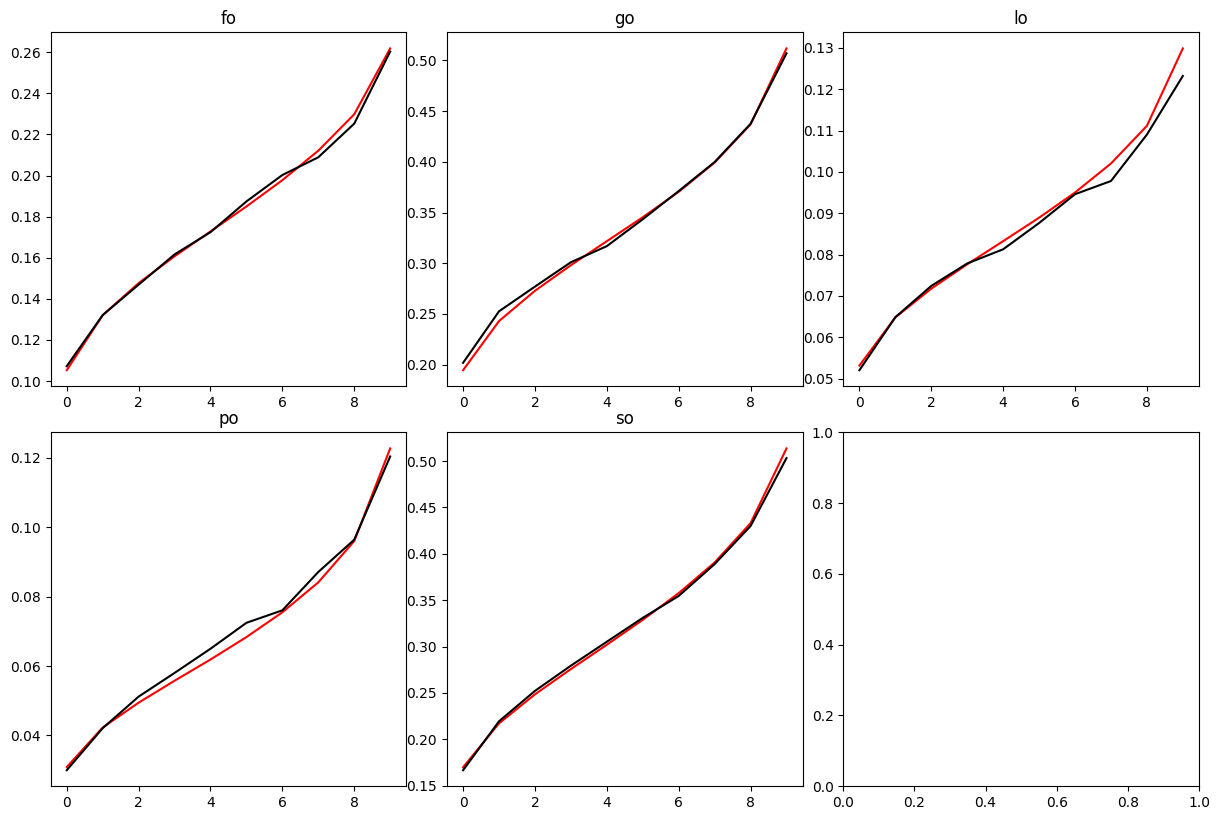

In [36]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(outs_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(0,0.35)


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

### Safe

In [130]:
%%time
# Neural network layers
# layers = (250,250,250,250,250,250,250,250)
layers = (25,25)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 100
# Alpha
alpha = 0.0005
# Random state
random_state = 1

safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(safe_filename)

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+2, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+3, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+4, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+5, max_iter=iters),

    
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=8, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=9, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=10, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=11, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=12, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(safe_dataset_train[pa_inputs2], safe_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

model_safe_relu_2525_100_20240424.sav
CPU times: total: 453 ms
Wall time: 40.2 s


In [131]:
# Predict safe types
safe_outputs = list(model_safe.classes_)
safe_outputs_pred = [x + "_pred" for x in safe_outputs]

proba = model_safe.predict_proba(safe_dataset_test[pa_inputs2])
for i, col in enumerate(safe_outputs_pred):
    safe_dataset_test[f'{col}'] = proba[:, i]

In [132]:
# Create deciles
for var in safe_outputs:
    safe_dataset_test[f'{var}_act'] = (safe_dataset_test['eventsModel'] == var).astype('int')
    safe_dataset_test[f'{var}_decile'] = pd.qcut(safe_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = safe_dataset_test.groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    # globals()[df_name] = safe_dataset_test[safe_dataset_test['year'].astype(int) >= 2022].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    # globals()[df_name] = safe_dataset_test[safe_dataset_test['venue_id'] == "3"].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()


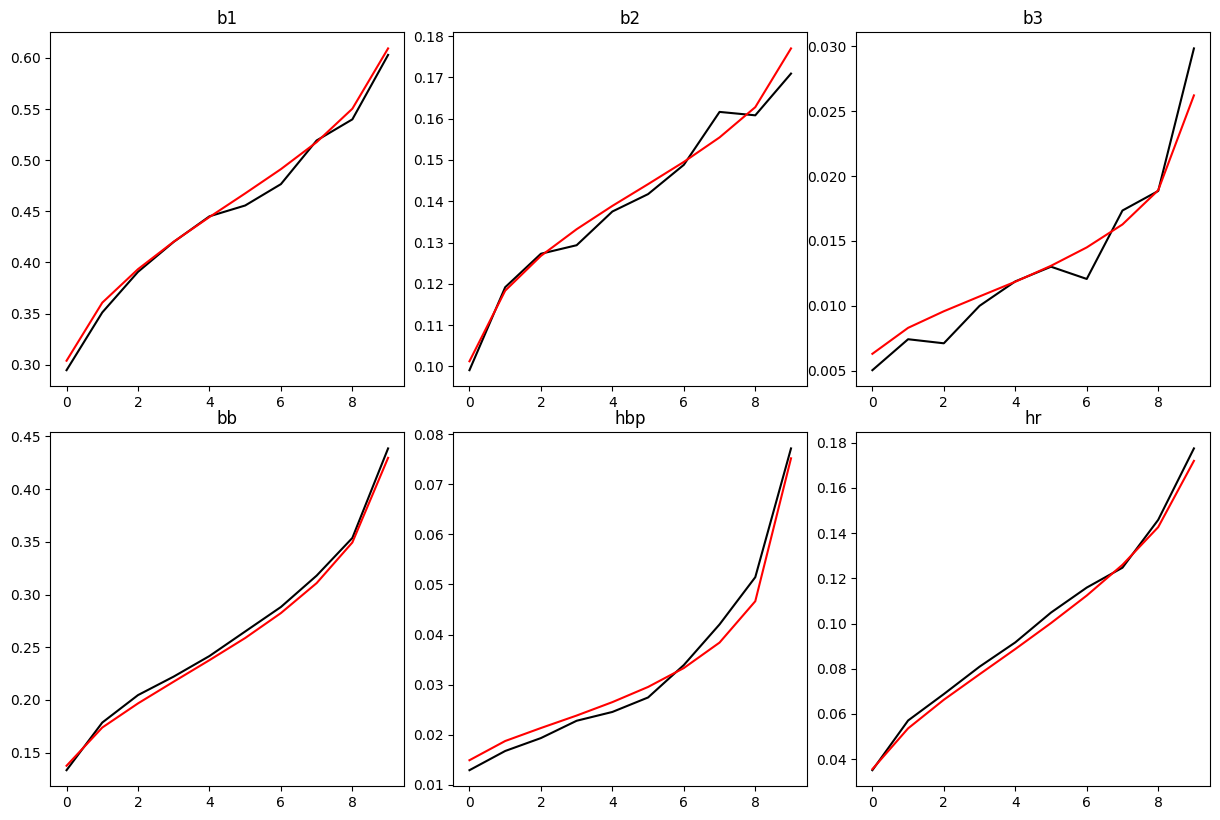

In [133]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())
    

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [41]:
adafadf

NameError: name 'adafadf' is not defined

In [ ]:
hr_df['hr_mse'] = (hr_df['hr_act'] - hr_df['hr_pred']) ** 2
hr_df['hr_mse'].mean()

In [ ]:
var = 'hr'
safe_dataset_test.groupby(f'{var}_decile')[[f'{var}_pred', f'{var}_act']].mean()

In [ ]:
adfa

In [ ]:
safe_dataset_test.groupby('decile')[['hr_pred', 'hr_act']].mean()

In [ ]:
safe_dataset_test.query('year == "2022" | year == "2023"')[['b1_pred', 'b1_act', 'b2_pred', 'b2_act', 'b3_pred', 'b3_act', 'hr_pred', 'hr_act', 'bb_pred', 'bb_act', 'hbp_pred', 'hbp_act']].mean()

In [ ]:
outs_dataset_test.query('year == "2022" | year == "2023"')[['fo_pred', 'fo_act', 'go_pred', 'go_act', 'lo_pred', 'lo_act', 'po_pred', 'po_act', 'so_pred', 'so_act']].mean()